### Example of how to use the planner (MPPI_Numba) and traction distribution map (TDM) for unicycle dynamics. 

### Semantic environments with different dimensions and distributions can be customized.

In [1]:
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.51, 0.51), std=(0.35, 0.35), cvar(0.10)=(0.02, 0.02) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.10)=(0.47, 0.47) (computed from 10000.0 saved samples)


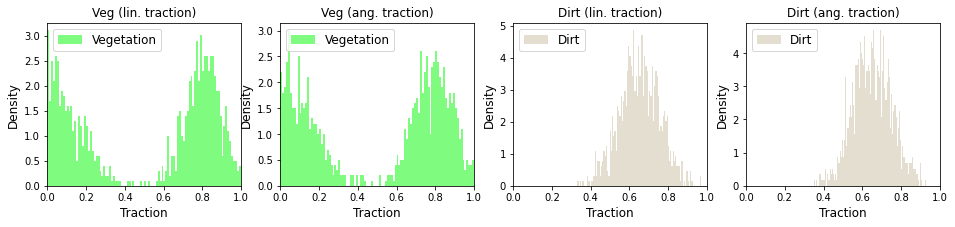

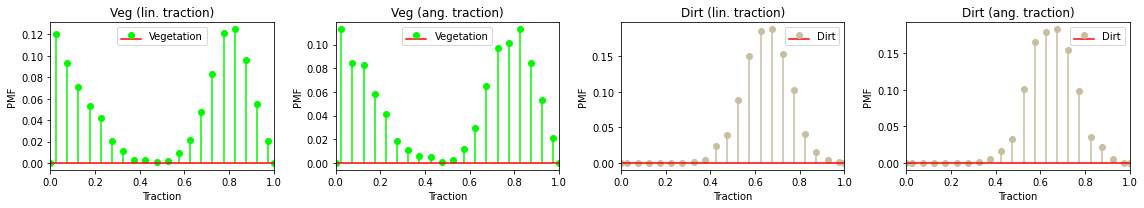

In [2]:
# Generate the distribution for bush and dirt (linear and angular tractions are the same for simplicity)
pmf_bounds = [0, 1.0]
bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]
dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

# PMF approximation of the traction parameters
num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)

LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

MPPI planner has initialized GPU memory after 0.37354063987731934 s
TDM has initialized GPU memory after 0.041031837463378906 s
TDM has initialized GPU memory after 0.03993558883666992 s


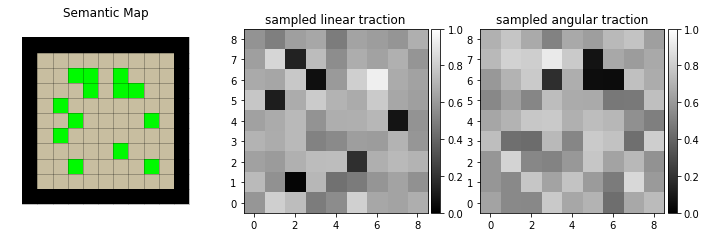

In [3]:
# --- Create and visualize the map ---
# Fixed a sampled environment
grid_shape = (9, 9)
mud_margin = 1 # Leave a corridor of dirt types near the edge
res = 1.0 # in meters
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.4 # 1.0
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1

xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0 # Determines the number of padding cells in the grid map allocated on GPU

# --- Choose one of the algorithms ---
use_tdm = True # Use the full traction distribution (ICRA23). Visualize the optimal control over samples of traction maps
use_det_dynamics = False # Use the cvar of traction distribution (ICRA23). Visualize multiple control samples over the worst-case traction map.
use_nom_dynamics_with_speed_map = False # Adjust time cost with worst-case speed (IROS22). Visualize multiple control samples over the worst-case traction map.
use_costmap = False # Not used in sim. Can be used to handle costmap2d from ROS.

assert use_tdm+use_det_dynamics+use_nom_dynamics_with_speed_map+use_costmap==1, "Only one of the methods can be chosen."
assert not use_costmap, "Interface with costmap2d not supported here."

# Configure the risk tolerance based on algorithm
if use_tdm:
  cvar_alpha = 0.2 # Risk tolerance for the objective
  alpha_dyn = 1.0 # Should be kept 1.0 (use full distribution), but can optionally sample from worst alpha_dyn quantile of traction distribution
elif use_det_dynamics:
  cvar_alpha = 1.0 # This param not used
  alpha_dyn = 0.2 # Use worst-case expected traction (dynamics) for rollouts.
elif use_nom_dynamics_with_speed_map:
  cvar_alpha = 1.0 # This param not used
  alpha_dyn = 0.2 # Use worst-case expected linear traction to adjust speed cost
else:
  cvar_alpha = 1.0
  alpha_dyn = 1.0

num_vis_state_rollouts = 100
if use_det_dynamics or use_nom_dynamics_with_speed_map or use_costmap:
  num_vis_state_rollouts = 1 # just visualize the best solution

# --- General configs for both MPPI and TDM. Fixed after objects are initialized ---
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # Current implementation works best if this is <= number of threads per block (<=1024)
  num_control_rollouts = 1024, # Same as number of blocks, can be more than 1024
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = num_vis_state_rollouts,
  max_map_dim =(15, 15), # Padded maps larger than this dim will be cropped to fit in GPU memory
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# --- Problem configuration. Can be changed for every replanning step. ---
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0, # Start state
    xgoal=xgoal, # Goal position

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01, # The smaller, the more terminal dist-to-goal is penalized
    cvar_alpha=cvar_alpha, # Risk tolerance of realized objectives (when use_tdm=True)
    alpha_dyn=alpha_dyn, # Risk tolerance used in the traction distribution (dynamics).

    dist_weight=1, #  Weight for dist-to-goal cost.

    lambda_weight=1.0, # Temperature param in MPPI
    num_opt=1, # Number of steps in each solve() function call.

    # Control and sample specification
    u_std=np.array([2.0, 3.0]), # Noise std for sampling linear and angular velocities.
    vrange = np.array([0.0, max_speed]), # Linear velocity range.
    wrange=np.array([-np.pi, np.pi]), # Angular velocity range.
)

# --- Construct the MPPI & TDM and initialize GPU memory based on cfg (slow) ---
mppi_planner = MPPI_Numba(cfg)
lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)

# --- Initialize linear and angular traction distribution from semantic map---
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                                  det_dynamics_cvar_alpha=mppi_params['alpha_dyn'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                                  det_dynamics_cvar_alpha=mppi_params['alpha_dyn'])


# Visualize semantic map, sampled linear and angular traction maps from distribution
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
lin_tdm_vis = TDM_Visualizer(lin_tdm)
lin_tdm_vis.draw(ax=axes[0])
axes[0].set_title("Semantic Map")

ax = axes[1]
traction_grid = lin_tdm.sample_grids_true_dist()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)

ax = axes[2]
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)
plt.show()

/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


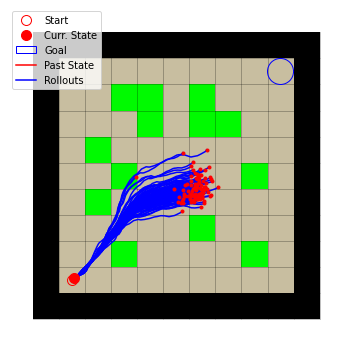

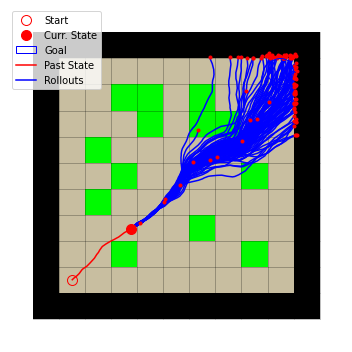

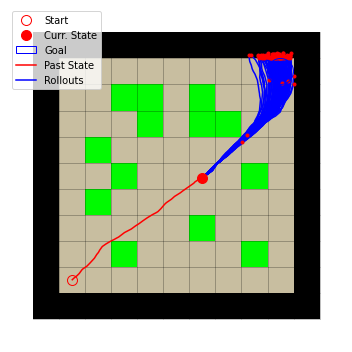

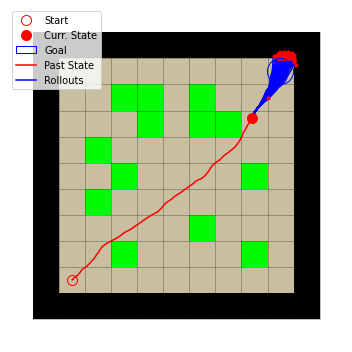

goal reached at t=10.50s


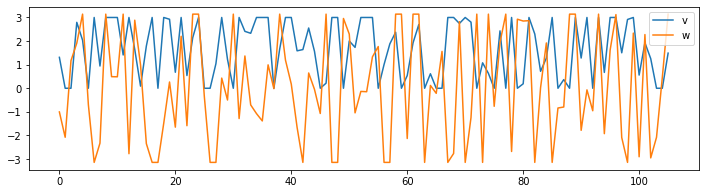

In [4]:
# For replanning, TDMs and MPPIs have to be reset() and configured with new maps and MPPI parameters
# Since the map doesn't change, we only reset once at the beginning.
lin_tdm.reset()
ang_tdm.reset()
mppi_planner.reset()
obstacle_map = None # np.zeros(semantic_grid.shape, dtype=np.int8)
unknown_map = None # np.zeros(semantic_grid.shape, dtype=np.int8)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    det_dynamics_cvar_alpha=mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    det_dynamics_cvar_alpha=mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# Loop
max_steps = 151
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]

  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.tight_layout()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={:.2f}s".format(t*cfg.dt))
    break

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(uhist[:,0], label='v')
ax.plot(uhist[:,1], label='w')
ax.legend()
plt.show()